In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
TRAIN_PATH = "../input/nlp-getting-started/train.csv"
TEST_PATH = "../input/nlp-getting-started/test.csv"
SAMPLE_SUBMISSION_PATH = "../input/nlp-getting-started/submission.csv"
SUBMISSION_PATH = "submission.csv"

In [3]:
train_ds=pd.read_csv(TRAIN_PATH)
test_ds=pd.read_csv(TEST_PATH)



import transformers
from transformers import BertTokenizer
from transformers import TFBertModel

import tensorflow as tf 
from tensorflow.keras.optimizers import Adam

In [4]:
TARGET="target"
MODEL_NAME = "bert-large-uncased"
MODEL_MAX_LENGTH = 60
MODEL_INPUT_IDS_COL = "input_ids"
MODEL_ATTENTION_MASK_COL = "attention_mask"

MODEL_DATATYPE = "int32"
MODEL_DENSE = 32
MODEL_DROPOUT = 0.2
MODEL_ACTIVATION = "relu"
MODEL_LAST_ACTIVATION = "sigmoid"
MODEL_LR = 6e-6
MODEL_LOSS = "binary_crossentropy"
MODEL_METRICS = ['accuracy']
MODEL_EPOCH = 2
MODEL_BATCH_SIZE = 10
MODEL_VAL_SIZE = 0.2

TRAIN_PATH = "../input/nlp-getting-started/train.csv"
TEST_PATH = "../input/nlp-getting-started/test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(

        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,

        return_attention_mask=True,

        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

train_input_ids,train_attention_masks = bert_encode(train,MODEL_MAX_LENGTH)
test_input_ids,test_attention_masks = bert_encode(test,MODEL_MAX_LENGTH)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [5]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(MODEL_MAX_LENGTH,),dtype=MODEL_DATATYPE)
    attention_masks = tf.keras.Input(shape=(MODEL_MAX_LENGTH,),dtype=MODEL_DATATYPE)

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(MODEL_DENSE,activation=MODEL_ACTIVATION)(output)
    output = tf.keras.layers.Dropout(MODEL_DROPOUT)(output)

    output = tf.keras.layers.Dense(1,activation=MODEL_LAST_ACTIVATION)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=MODEL_LR), loss=MODEL_LOSS, metrics=MODEL_METRICS)
    return model


bert_model = TFBertModel.from_pretrained(MODEL_NAME)

model = create_model(bert_model)
model.summary()

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

2022-08-29 15:36:40.742421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 15:36:40.743766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 15:36:40.744576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 15:36:40.745488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
history = model.fit(
    [train_input_ids,train_attention_masks],
    train[TARGET],
    validation_split=MODEL_VAL_SIZE,
    epochs=MODEL_EPOCH,
    batch_size=MODEL_BATCH_SIZE)

2022-08-29 15:36:57.713248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
609/609 [==============================] - 193s 286ms/step - loss: 0.4947 - accuracy: 0.7783 - val_loss: 0.3813 - val_accuracy: 0.8404
Epoch 2/2
609/609 [==============================] - 169s 278ms/step - loss: 0.3786 - accuracy: 0.8493 - val_loss: 0.3627 - val_accuracy: 0.8398


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


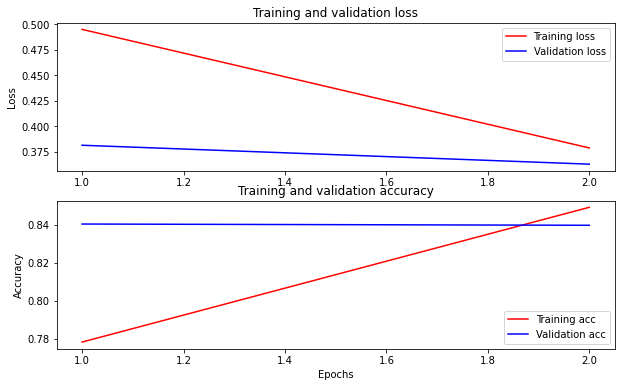

In [7]:
import matplotlib.pyplot as plt 
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [8]:
preds=model.predict([test_input_ids,test_attention_masks])

In [9]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [10]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [11]:
# # sub = pd.read_csv('/kaggle/working/nlp-getting-started/sample_submission.csv')
# sub[TARGET] = np.round(preds).astype(int)
# sub.to_csv('/kaggle/working/sample_submission.csv',index=False)
# sub.head()

In [12]:
# sub = pd.read_csv('/kaggle/working/nlp-getting-started/sample_submission.csv')
submission[TARGET] = np.round(preds).astype(int)
submission.to_csv('sample_submission.csv',index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
